In [1]:
import os, sys
sys.path.insert(0, os.path.join(os.getenv('HOME'), 'StarNet'))
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits as pyfits
import umap
from sklearn.datasets import load_iris

from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score


from starnet.utils.data_utils.augment import convolve_spectrum
from starnet.utils.data_utils.restructure_spectrum import rebin, continuum_normalize, ensure_constant_sampling


/home/nrpu88/jupyter_py3/lib/python3.6/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/home/nrpu88/jupyter_py3/lib/python3.6/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/home/nrpu88/jupyter_py3/lib/python3.6/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for ftp://ftp.stsci.edu/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/home/nrpu88/jupyter_py3/lib/python3.6/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for ftp://ftp.stsci.edu/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


In [2]:
# Define parameters needed for continuum fitting
LINE_REGIONS = [[4210, 4240], [4250, 4410], [4333, 4388], [4845, 4886], [5160, 5200], [5874, 5916], [6530, 6590]]
SEGMENTS_STEP = 10.  # divide the spectrum into segments of 10 Angstroms

In [3]:
home = os.getenv('HOME')
scratch = os.getenv('SCRATCH')
starnet_data_folder = os.path.join(home, 'StarNet/starnet/data/')
intrigoss_grid_path = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/grids/intrigoss/train/') 
phoenix_grid_path = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/grids/phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/train/') 
phoenix_wave_path = home+'/'+'/projects/rrg-kyi/group_writable/spectra/grids/phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/'
ambre_grid_path = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/grids/AMBRE/train/')
obs_wave_filepath = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/UVES_4835-5395.npy')
wave_grid_obs = np.load(obs_wave_filepath)

### Create functions for loading Phoenix and INTRIGOSS spectra

#### Phoenix...

In [4]:
def get_phoenix_spectrum(spectrum_path, wave_grid_path):
    
    """
    Given the path of a Phoenix spectrum .fits file, this function retrieves the flux and wavelength data
    
    INPUT: path: The path to the Phoenix spectrum file, e.g. '/path/to/lte04000-1.00-1.0.Alpha=+0.50.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'
    
    RETURNS: wav: wavelength data
             flux: flux data
    """
    
    hdulist_spectrum = pyfits.open(spectrum_path)
    hdulist_wavegrid = pyfits.open(wave_grid_path)
    
    flux = hdulist_spectrum[0].data
    wav = hdulist_wavegrid[0].data
    
    # For Phoenix, need to convert from vacuum to air wavelengths.
    # The IAU standard for conversion from air to vacuum wavelengths is given
    # in Morton (1991, ApJS, 77, 119). For vacuum wavelengths (VAC) in
    # Angstroms, convert to air wavelength (AIR) via:
    #  AIR = VAC / (1.0 + 2.735182E-4 + 131.4182 / VAC^2 + 2.76249E8 / VAC^4)
    wav = wav / (
            1.0 + 2.735182E-4 + 131.4182 / wav ** 2 + 2.76249E8 / wav ** 4)
    
    return wav, flux

#### INTRIGOSS...

In [5]:
def get_intrigoss_spectrum(path):
    
    """
    Given the path of an INTRIGOSS spectrum .fits file, this function retrieves the flux and wavelength data
    
    INPUT: path: The path to the INTRIGOSS spectrum file, e.g. '/path/to/alpp050_am100_t4000g10_v1_f.fits'
    
    RETURNS: wav: wavelength data
             flux: flux data
    """
    
    hdulist = pyfits.open(path)
    flux_data = hdulist[1].data
    
    wav = flux_data['wavelength']
    flux = flux_data['surface_flux']
    
    return wav, flux

In [6]:
def get_ambre_spectrum(path):
    
    """
    Given the path of an AMBRE spectrum .fits file, this function retrieves the flux and wavelength data
    
    INPUT: path: The path to the AMBRE spectrum file, e.g. '/path/to/alpp050_am100_t4000g10_v1_f.AMBRE'
    
    RETURNS: wav: wavelength data
             flux: flux data
    """
    flux = np.genfromtxt(path,usecols=-1)
    wav = np.genfromtxt(path,usecols= 0)
    
    return wav, flux

### Define requested stellar parameters

In [7]:
def intrigoss_one_file(name):


    wav_intrigoss,flux_intrigoss = get_intrigoss_spectrum(intrigoss_grid_path+name)

    return wav_intrigoss,flux_intrigoss

In [8]:
def phoenix_one_file(name):


    wavegrid_path = os.path.join(phoenix_wave_path, 'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
    wav_phoenix, flux_phoenix = get_phoenix_spectrum(phoenix_grid_path+name, wavegrid_path)


    return wav_phoenix,flux_phoenix

In [9]:
def ambre_one_file(name):

    wav_ambre, flux_ambre = get_ambre_spectrum(ambre_grid_path+name)
    

    return wav_ambre,flux_ambre

In [10]:
def pre_processor_phoenix(wav_phoenix,flux_phoenix):


# Trim the wavelength and flux arrays according to observed wave grid
    extension = 10  # Angstroms
    wave_min_request = wave_grid_obs[0] - extension
    wave_max_request = wave_grid_obs[-1] + extension
    #wave_indices_intrigoss = (wav_intrigoss > wave_min_request) & (wav_intrigoss < wave_max_request)
    wave_indices_phoenix = (wav_phoenix > wave_min_request) & (wav_phoenix < wave_max_request)
    #wave_indices_ambre = (wav_ambre > wave_min_request) & (wav_ambre < wave_max_request)
    #wav_intrigoss = wav_intrigoss[wave_indices_intrigoss]
    wav_phoenix = wav_phoenix[wave_indices_phoenix]
    #wav_ambre = wav_ambre[wave_indices_ambre]
    #flux_intrigoss = flux_intrigoss[wave_indices_intrigoss]
    flux_phoenix = flux_phoenix[wave_indices_phoenix]
    #flux_ambre = flux_ambre[wave_indices_ambre]

# Degrade resolution
    #err_intrigoss = np.zeros(len(flux_intrigoss))
    err_phoenix = np.zeros(len(flux_phoenix))
    #err_ambre = np.zeros(len(flux_ambre))
    #_, flux_intrigoss, _ = convolve_spectrum(wav_intrigoss, flux_intrigoss, err_intrigoss, to_resolution=47000)
    _, flux_phoenix, _ = convolve_spectrum(wav_phoenix, flux_phoenix, err_phoenix, to_resolution=47000)
    #_, flux_ambre, _ = convolve_spectrum(wav_ambre, flux_ambre, err_ambre, to_resolution=47000)

# Rebin to UVES wave grid
    #flux_intrigoss = rebin(wave_grid_obs, wav_intrigoss, flux_intrigoss)
    flux_phoenix = rebin(wave_grid_obs, wav_phoenix, flux_phoenix)
    #flux_ambre = rebin(wave_grid_obs, wav_ambre, flux_ambre)

# Continuum normalize the spectra
    #flux_intrigoss, _ = continuum_normalize(flux_intrigoss, LINE_REGIONS, wave_grid_obs, SEGMENTS_STEP)
    flux_phoenix, _ = continuum_normalize(flux_phoenix, LINE_REGIONS, wave_grid_obs, SEGMENTS_STEP)
    #flux_ambre, _ = continuum_normalize(flux_ambre, LINE_REGIONS, wave_grid_obs, SEGMENTS_STEP)

    #print('DONE')
    
    return flux_phoenix

# Mask telluric lines
#flux_intrigoss = mask_tellurics('telluric_lines.txt', flux_intrigoss, wave_grid_obs
#flux_phoenix = mask_tellurics('telluric_lines.txt', flux_phoenix, wave_grid_obs)
#flux_ambre = mask_tellurics('telluric_lines.txt', flux_ambre, wave_grid_obs)

In [11]:
def pre_processor_intrigoss(wav_intrigoss,flux_intrigoss):


# Trim the wavelength and flux arrays according to observed wave grid
    extension = 10  # Angstroms
    wave_min_request = wave_grid_obs[0] - extension
    wave_max_request = wave_grid_obs[-1] + extension
    wave_indices_intrigoss = (wav_intrigoss > wave_min_request) & (wav_intrigoss < wave_max_request)
    #wave_indices_phoenix = (wav_phoenix > wave_min_request) & (wav_phoenix < wave_max_request)
    #wave_indices_ambre = (wav_ambre > wave_min_request) & (wav_ambre < wave_max_request)
    wav_intrigoss = wav_intrigoss[wave_indices_intrigoss]
    #wav_phoenix = wav_phoenix[wave_indices_phoenix]
    #wav_ambre = wav_ambre[wave_indices_ambre]
    flux_intrigoss = flux_intrigoss[wave_indices_intrigoss]
    #flux_phoenix = flux_phoenix[wave_indices_phoenix]
    #flux_ambre = flux_ambre[wave_indices_ambre]

# Degrade resolution
    err_intrigoss = np.zeros(len(flux_intrigoss))
    #err_phoenix = np.zeros(len(flux_phoenix))
    #err_ambre = np.zeros(len(flux_ambre))
    _, flux_intrigoss, _ = convolve_spectrum(wav_intrigoss, flux_intrigoss, err_intrigoss, to_resolution=47000)
    #_, flux_phoenix, _ = convolve_spectrum(wav_phoenix, flux_phoenix, err_phoenix, to_resolution=47000)
    #_, flux_ambre, _ = convolve_spectrum(wav_ambre, flux_ambre, err_ambre, to_resolution=47000)

# Rebin to UVES wave grid
    flux_intrigoss = rebin(wave_grid_obs, wav_intrigoss, flux_intrigoss)
    #flux_phoenix = rebin(wave_grid_obs, wav_phoenix, flux_phoenix)
    #flux_ambre = rebin(wave_grid_obs, wav_ambre, flux_ambre)

# Continuum normalize the spectra
    flux_intrigoss, _ = continuum_normalize(flux_intrigoss, LINE_REGIONS, wave_grid_obs, SEGMENTS_STEP)
    #flux_phoenix, _ = continuum_normalize(flux_phoenix, LINE_REGIONS, wave_grid_obs, SEGMENTS_STEP)
    #flux_ambre, _ = continuum_normalize(flux_ambre, LINE_REGIONS, wave_grid_obs, SEGMENTS_STEP)

    #print('DONE')
    
    return flux_intrigoss

# Mask telluric lines
#flux_intrigoss = mask_tellurics('telluric_lines.txt', flux_intrigoss, wave_grid_obs
#flux_phoenix = mask_tellurics('telluric_lines.txt', flux_phoenix, wave_grid_obs)
#flux_ambre = mask_tellurics('telluric_lines.txt', flux_ambre, wave_grid_obs)

In [12]:
def pre_processor_ambre(wav_ambre,flux_ambre):


# Trim the wavelength and flux arrays according to observed wave grid
    extension = 10  # Angstroms
    wave_min_request = wave_grid_obs[0] - extension
    wave_max_request = wave_grid_obs[-1] + extension
    #wave_indices_intrigoss = (wav_intrigoss > wave_min_request) & (wav_intrigoss < wave_max_request)
    #wave_indices_phoenix = (wav_phoenix > wave_min_request) & (wav_phoenix < wave_max_request)
    wave_indices_ambre = (wav_ambre > wave_min_request) & (wav_ambre < wave_max_request)
    #wav_intrigoss = wav_intrigoss[wave_indices_intrigoss]
    #wav_phoenix = wav_phoenix[wave_indices_phoenix]
    wav_ambre = wav_ambre[wave_indices_ambre]
    #flux_intrigoss = flux_intrigoss[wave_indices_intrigoss]
    #flux_phoenix = flux_phoenix[wave_indices_phoenix]
    flux_ambre = flux_ambre[wave_indices_ambre]

# Degrade resolution
    #err_intrigoss = np.zeros(len(flux_intrigoss))
    #err_phoenix = np.zeros(len(flux_phoenix))
    err_ambre = np.zeros(len(flux_ambre))
    #_, flux_intrigoss, _ = convolve_spectrum(wav_intrigoss, flux_intrigoss, err_intrigoss, to_resolution=47000)
    #_, flux_phoenix, _ = convolve_spectrum(wav_phoenix, flux_phoenix, err_phoenix, to_resolution=47000)
    _, flux_ambre, _ = convolve_spectrum(wav_ambre, flux_ambre, err_ambre, to_resolution=47000)

# Rebin to UVES wave grid
    #flux_intrigoss = rebin(wave_grid_obs, wav_intrigoss, flux_intrigoss)
    #flux_phoenix = rebin(wave_grid_obs, wav_phoenix, flux_phoenix)
    flux_ambre = rebin(wave_grid_obs, wav_ambre, flux_ambre)

# Continuum normalize the spectra
    #flux_intrigoss, _ = continuum_normalize(flux_intrigoss, LINE_REGIONS, wave_grid_obs, SEGMENTS_STEP)
    #flux_phoenix, _ = continuum_normalize(flux_phoenix, LINE_REGIONS, wave_grid_obs, SEGMENTS_STEP)
    flux_ambre, _ = continuum_normalize(flux_ambre, LINE_REGIONS, wave_grid_obs, SEGMENTS_STEP)

    #print('DONE')
    
    return flux_ambre

# Mask telluric lines
#flux_intrigoss = mask_tellurics('telluric_lines.txt', flux_intrigoss, wave_grid_obs
#flux_phoenix = mask_tellurics('telluric_lines.txt', flux_phoenix, wave_grid_obs)
#flux_ambre = mask_tellurics('telluric_lines.txt', flux_ambre, wave_grid_obs)

In [13]:
f_p = []
#p_count = 0
for root, dirs, files in os.walk(phoenix_grid_path):
    for name in files:
        wav_phoenix,flux_phoenix = phoenix_one_file(name)
        f_p.append(pre_processor_phoenix(wav_phoenix,flux_phoenix))
        #p_count = p_count + 1 
        #if p_count >= 10:
        #    break
f_p = np.asarray(f_p)
#print(f_p.shape)

/home/nrpu88/jupyter_py3/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:165: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/home/nrpu88/jupyter_py3/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:166: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value


In [14]:
f_a = []
#a_count = 0
for root, dirs, files in os.walk(ambre_grid_path):
    for name in files:
        wav_ambre,flux_ambre = ambre_one_file(name)
        f_a.append(pre_processor_ambre(wav_ambre,flux_ambre))
        #a_count = a_count + 1 
        #if a_count >= 10:
        #    break
f_a = np.asarray(f_a)
#print(f_a.shape)

In [15]:
f_i = []
#i_count = 0
for root, dirs, files in os.walk(intrigoss_grid_path):
    for name in files:
        wav_intrigoss,flux_intrigoss = intrigoss_one_file(name)
        f_i.append(pre_processor_intrigoss(wav_intrigoss,flux_intrigoss))
#        i_count = i_count + 1 
#        if i_count >= 10:
#            break
f_i = np.asarray(f_i)
#print(f_i.shape)

In [16]:
grid_data = []
for i in f_i:
    grid_data.append(i)
for j in f_p:
    grid_data.append(j)
for k in f_a:
    grid_data.append(k)

grid_data = np.asarray(grid_data)
#print(grid_data.shape)


### Load in the spectra, degrade resolution, rebin to UVES, and then continuum normalize

### Plot spectra

In [17]:
reducer = umap.UMAP(init = 'random')

In [18]:
embedding = reducer.fit_transform(grid_data)
#embedding.shape

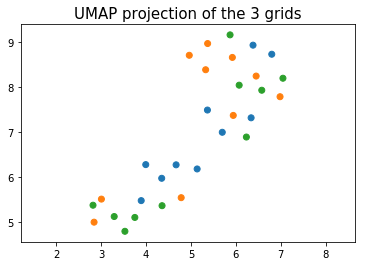

In [22]:
grid_target=[]
for i in range(len(f_i)):
    grid_target.append(0)
for j in range(len(f_p)):
    grid_target.append(1)
for k in range(len(f_a)):
    grid_target.append(2)

#print(grid_target)


plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in grid_target])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the 3 grids', fontsize=15);